# Get simulation results

LSM simulation results may be extracted and handled using an LSMsimulation object.

## Getting an LSMsimulation object

A simulation may be loaded from the database, by quering its parameters.
For example:

In [1]:
from hera.simulations.LSM.toolkit import LSMToolkit
from unum.units import *

LSM = LSMToolkit(projectName="documentation")
LSM.getSimulations(duration=1*min)

A list of all available simulations in the DB is available using the next function:

In [2]:
LSM.listSimulations()

KeyError: 'params'

Finally, a simulation object may be initialized directly using the source file's directory:

In [3]:
simulation = LSM.singleSimulation("netcdf")

## Getting the concentration

Once the simulation object is created, the concentration may be extracted.
One can choose the mass of agent disperesed and the units of the time steps and of the agent's mass per cubic meter.
The default values are presented in the next example.

In [4]:
from unum.units import *
Concentration = simulation.getConcentration(Q=1*kg, time_units=min, q_units=mg)
Concentration

<xarray.Dataset>
Dimensions:   (datetime: 20, x: 1000, y: 1000, z: 1)
Coordinates:
  * x         (x) float64 -995.0 -985.0 -975.0 ... 8.975e+03 8.985e+03 8.995e+03
  * z         (z) float64 0.0
  * y         (y) float64 -4.995e+03 -4.985e+03 ... 4.985e+03 4.995e+03
  * datetime  (datetime) datetime64[ns] 2016-01-01T12:00:30 ... 2016-01-01T12...
Data variables:
    dDosage   (datetime, y, x, z) float64 dask.array<chunksize=(20, 1000, 1000, 1), meta=np.ndarray>
    C         (datetime, y, x, z) float64 dask.array<chunksize=(20, 1000, 1000, 1), meta=np.ndarray>
Attributes:
    dt:       0.5 [min]
    Q:        1000000.0 [mg]
    C:        1.0 [mg/m3]

## Getting the dosage

Similarly, the doage may be extracted:

In [5]:
Dosage = simulation.getDosage(Q=1*kg, time_units=min, q_units=mg)
Dosage

<xarray.Dataset>
Dimensions:   (datetime: 21, x: 1000, y: 1000, z: 1)
Coordinates:
  * x         (x) float64 -995.0 -985.0 -975.0 ... 8.975e+03 8.985e+03 8.995e+03
  * z         (z) float64 0.0
  * y         (y) float64 -4.995e+03 -4.985e+03 ... 4.985e+03 4.995e+03
  * datetime  (datetime) datetime64[ns] 2016-01-01T12:00:00 ... 2016-01-01T12...
Data variables:
    Dosage    (datetime, y, x, z) float64 dask.array<chunksize=(21, 1000, 1000, 1), meta=np.ndarray>
Attributes:
    dt:       0.5 [min]
    Q:        1000000.0 [mg]
    C:        1.0 [mg/m3]

## Merging simulations

Sometimes we wish to merge results of different simulations, by which we mean summing the dosage and concentration of several runs.
Here we will demonstrate how it can be done.
For the next example, we will first create another results xarray, which in our case is the same to the concentation we've already got,
except it's shifted 500 meters to the north:

In [28]:
ConcentrationShifted = Concentration.copy()
ConcentrationShifted["y"] = (ConcentrationShifted["y"].values)+500
ConcentrationShifted

<xarray.Dataset>
Dimensions:   (datetime: 20, x: 1000, y: 1000, z: 1)
Coordinates:
  * x         (x) float64 -995.0 -985.0 -975.0 ... 8.975e+03 8.985e+03 8.995e+03
  * z         (z) float64 0.0
  * y         (y) float64 -4.495e+03 -4.485e+03 ... 5.485e+03 5.495e+03
  * datetime  (datetime) datetime64[ns] 2016-01-01T12:00:30 ... 2016-01-01T12...
Data variables:
    dDosage   (datetime, y, x, z) float64 dask.array<chunksize=(20, 1000, 1000, 1), meta=np.ndarray>
    C         (datetime, y, x, z) float64 dask.array<chunksize=(20, 1000, 1000, 1), meta=np.ndarray>
Attributes:
    dt:       0.5 [min]
    Q:        1000000.0 [mg]
    C:        1.0 [mg/m3]

The merged xarray is calculated this way:

In [29]:
ConcentrationMerge = LSM.analysis.coordinateHandler.combineXarrays(xarrayList=[Concentration,ConcentrationShifted],dims=["x","y","datetime"])
ConcentrationMerge

<xarray.Dataset>
Dimensions:   (datetime: 20, x: 1000, y: 1050)
Coordinates:
    z         float64 0.0
  * x         (x) float64 -995.0 -985.0 -975.0 ... 8.975e+03 8.985e+03 8.995e+03
  * y         (y) float64 -4.995e+03 -4.985e+03 ... 5.485e+03 5.495e+03
  * datetime  (datetime) datetime64[ns] 2016-01-01T12:00:30 ... 2016-01-01T12...
Data variables:
    dDosage   (datetime, y, x) float64 dask.array<chunksize=(20, 1050, 1000), meta=np.ndarray>
    C         (datetime, y, x) float64 dask.array<chunksize=(20, 1050, 1000), meta=np.ndarray>

Notice that the xarrayList parameter may get any nomber of xarrays to merge.
Below are plots of the maximum concentration in time for each plot for the two individual concentration xarrays and the combined one.

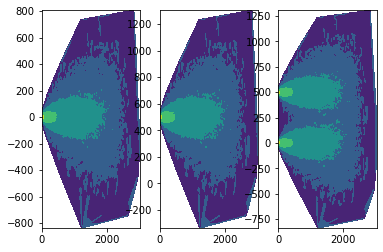

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
MaxConcentration = Concentration.max(dim="datetime").to_dataframe().reset_index()
MaxConcentration = MaxConcentration.loc[MaxConcentration.C>0]
MaxConcentrationShifted = ConcentrationShifted.max(dim="datetime").to_dataframe().reset_index()
MaxConcentrationShifted = MaxConcentrationShifted.loc[MaxConcentrationShifted.C>0]
MaxConcentrationMerge = ConcentrationMerge.max(dim="datetime").to_dataframe().reset_index()
MaxConcentrationMerge = MaxConcentrationMerge.loc[MaxConcentrationMerge.C>0]

fig, axs = plt.subplots(1,3)
levels = [0.0001,0.001,0.01,0.1,1,10]
axs[0].tricontourf(MaxConcentration.x,MaxConcentration.y,MaxConcentration.C,norm=LogNorm(),levels=levels)
axs[1].tricontourf(MaxConcentrationShifted.x,MaxConcentrationShifted.y,MaxConcentrationShifted.C,norm=LogNorm(),levels=levels)
axs[2].tricontourf(MaxConcentrationMerge.x,MaxConcentrationMerge.y,MaxConcentrationMerge.C,norm=LogNorm(),levels=levels)